In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
# Load the uploaded CSV file
data = pd.read_csv('filtered_data2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          207 non-null    int64  
 1   Name          207 non-null    object 
 2   Platform      207 non-null    object 
 3   Year          206 non-null    float64
 4   Genre         207 non-null    object 
 5   Publisher     207 non-null    object 
 6   NA_Sales      207 non-null    float64
 7   EU_Sales      207 non-null    float64
 8   JP_Sales      207 non-null    float64
 9   Other_Sales   207 non-null    float64
 10  Global_Sales  207 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 17.9+ KB


In [3]:
# Calculate the proportion of sales in each area (NA, EU, JP, Other) for each game
# These proportions are relative to the global sales of each game

data['NA_Sales_Prop'] = data['NA_Sales'] / data['Global_Sales']
data['EU_Sales_Prop'] = data['EU_Sales'] / data['Global_Sales']
data['JP_Sales_Prop'] = data['JP_Sales'] / data['Global_Sales']
data['Other_Sales_Prop'] = data['Other_Sales'] / data['Global_Sales']

# Display the updated dataframe with the new columns
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_Prop,EU_Sales_Prop,JP_Sales_Prop,Other_Sales_Prop
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,0.501450,0.350737,0.045564,0.102248
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,0.722664,0.088966,0.169235,0.019135
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,0.442490,0.359576,0.105807,0.092406
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,0.477273,0.333636,0.099394,0.089697
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,0.359260,0.283392,0.325789,0.031878


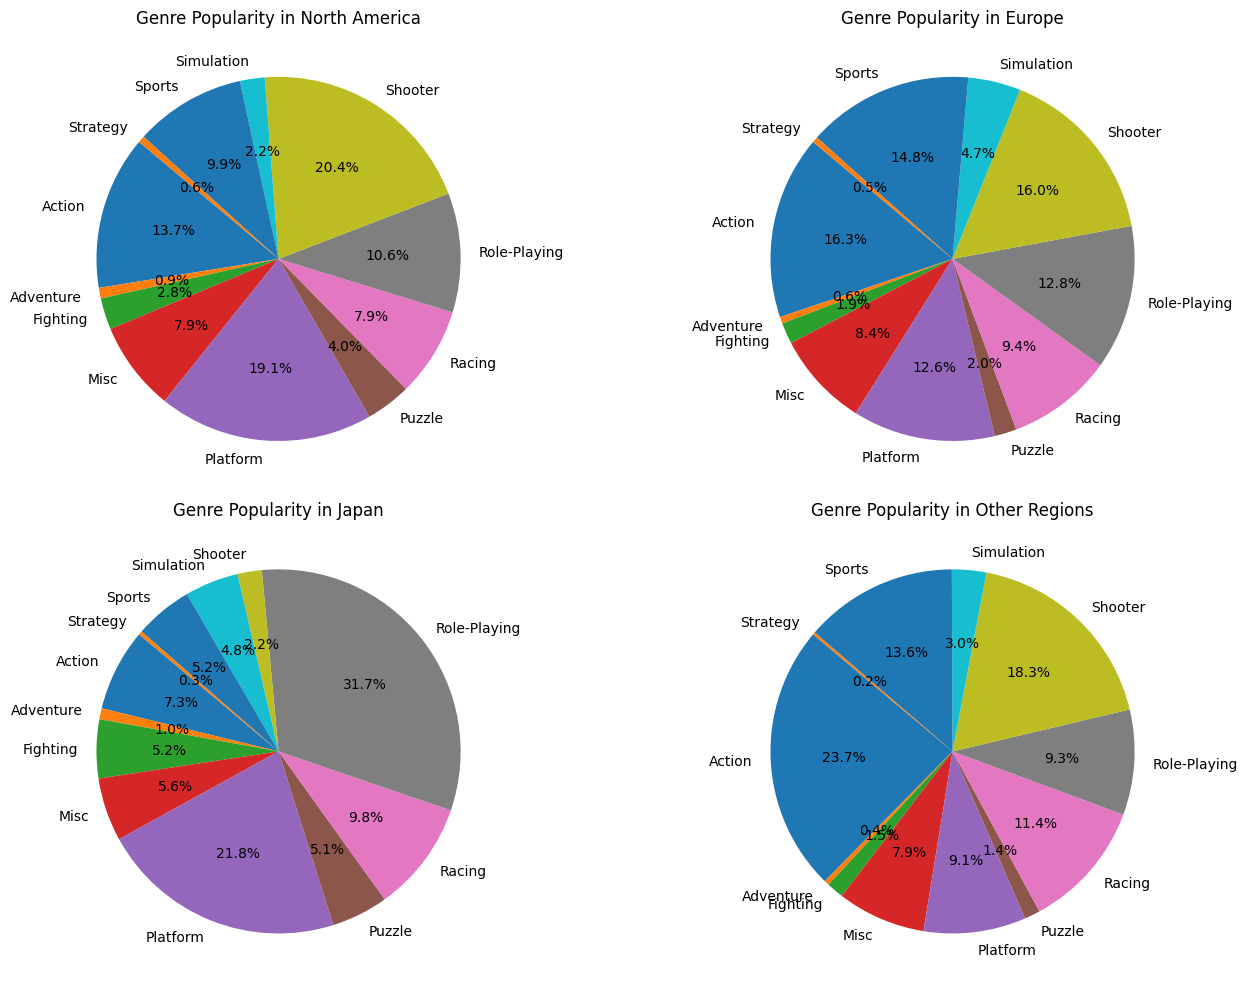

In [4]:
# Aggregate Sales by Genre for each region
sales_by_genre = data.groupby('Genre').agg({
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Other_Sales': 'sum'
}).reset_index()

# Calculate market share (proportion) of each genre in each region
# This is done by dividing the genre sales by the total sales in that region for each genre
total_sales_by_region = sales_by_genre.sum(numeric_only=True)
sales_by_genre_prop = sales_by_genre.set_index('Genre').divide(total_sales_by_region, axis=1).reset_index()

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for each region
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
region_titles = ['North America', 'Europe', 'Japan', 'Other Regions']
for ax, region, title in zip(axs.flatten(), regions, region_titles):
    ax.pie(sales_by_genre_prop[region], labels=sales_by_genre_prop['Genre'], autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Genre Popularity in {title}')

plt.tight_layout()
plt.show()


In [5]:
# Deleting the specified columns from the dataframe as they are deemed irrelevant for the analysis
data_cleaned = data.drop(['Rank', 'Platform', 'Year', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)

# Display the first few rows of the updated dataframe to verify the changes
data_cleaned.head()

,Name,Genre,NA_Sales_Prop,EU_Sales_Prop,JP_Sales_Prop,Other_Sales_Prop
0,Wii Sports,Sports,0.501450,0.350737,0.045564,0.102248
1,Super Mario Bros.,Platform,0.722664,0.088966,0.169235,0.019135
2,Mario Kart Wii,Racing,0.442490,0.359576,0.105807,0.092406
3,Wii Sports Resort,Sports,0.477273,0.333636,0.099394,0.089697
4,Pokemon Red/Pokemon Blue,Role-Playing,0.359260,0.283392,0.325789,0.031878


In [6]:
# To transform the data to have "Name", "Genre", "Sales_Prop", and "Area" as columns,
# we need to melt the current dataframe so that the sales proportion columns become a single "Sales_Prop" column,
# and the area is indicated in a new "Area" column.
# Melt the dataframe
data_long = pd.melt(data_cleaned, id_vars=['Name', 'Genre'], value_vars=['NA_Sales_Prop', 'EU_Sales_Prop', 'JP_Sales_Prop', 'Other_Sales_Prop'], var_name='Area', value_name='Sales_Prop')

# Replace the area column values to more readable form
data_long['Area'] = data_long['Area'].map({
    'NA_Sales_Prop': 'North America',
    'EU_Sales_Prop': 'Europe',
    'JP_Sales_Prop': 'Japan',
    'Other_Sales_Prop': 'Other'
})

# Display the first few rows of the transformed dataframe
data_long.head()

,Name,Genre,Area,Sales_Prop
0,Wii Sports,Sports,North America,0.501450
1,Super Mario Bros.,Platform,North America,0.722664
2,Mario Kart Wii,Racing,North America,0.442490
3,Wii Sports Resort,Sports,North America,0.477273
4,Pokemon Red/Pokemon Blue,Role-Playing,North America,0.359260


random forest

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

random_seed=42

# Preparing the data for the model
# One-hot encode the categorical variables "Genre" and "Area"
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data_long[['Genre', 'Area']])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, data_long['Sales_Prop'], test_size=0.2)

# Fitting the Random Forest model
RFR = RandomForestRegressor(n_estimators=1000,  # Number of trees in the forest
    criterion='squared_error',  # Function to measure the quality of a split
    max_depth=3,    # Maximum depth of the tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    bootstrap=True,  # Whether bootstrap samples are used when building trees
    oob_score=False,  # Whether to use out-of-bag samples to estimate the generalization accuracy
    n_jobs=-1,  # Number of jobs to run in parallel (-1 means using all processors)
    random_state=random_seed,  # Controls both the randomness of the bootstrapping of the samples and the sampling of the features
    verbose=0,  # Controls verbosity of the tree building process
    warm_start=False)
RFR.fit(X_train, y_train)

# Making predictions on the test set
y_pred = RFR.predict(X_test)

C:\Users\wuzhu\mambaforge\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmse, r2

(0.1199203912158174, 0.6213541755805321)

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RFR, encoded_features, data_long['Sales_Prop'], cv=10, scoring='neg_mean_absolute_error')
mean_score_RFR = scores.mean()
mean_score_RFR

-0.09757641292550581

gradient boosting trees

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.01, max_depth=3,random_state=random_seed).fit(X_train, y_train)
y_pred_GBR = GBR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))
r2 = r2_score(y_test, y_pred_GBR)
rmse, r2

(0.10847882860338723, 0.6901602936424054)

In [11]:
scores_GBR = cross_val_score(GBR, encoded_features, data_long['Sales_Prop'], cv=10, scoring='neg_mean_absolute_error')
mean_score_GBR = scores_GBR.mean()
mean_score_GBR

-0.08330869553271317

In [12]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
import xgboost as xgb

In [14]:
XGB= xgb.XGBRegressor(random_state=random_seed, objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.01,
                max_depth=3, alpha=0, n_estimators=2000)
XGB.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, ...)

In [15]:
y_pred_XGB = XGB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
r2 = r2_score(y_test, y_pred_XGB)
rmse, r2

(0.10731081126653219, 0.6967966084257508)

In [16]:
scores_XGB = cross_val_score(XGB, encoded_features, data_long['Sales_Prop'], cv=10, scoring='neg_mean_absolute_error')
mean_score_XGB = scores_XGB.mean()
mean_score_XGB

-0.08365920816684405